## Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

## Get the Data 

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Staples_Lab_Work/Prepared_Testing_Data_983val.csv')

In [3]:
dataset.head()

,Image #,Device #,Channel length (um),Channel width (um),Frequency (Hz),Time taken (s),Distance (mm),Pressure,Condition,Cross-sectional area (mm2),Flowing Forward/Backward?,Flow rate (mm3/s),Frequency (bpm),Pressure (mmHg)
0,7410,2,11200,2300,0.5,26.95,38.4,0.13,No microneedle array,0.072966,Forward,0.103966,30,97.50806
1,7411,2,11200,2300,0.5,31.90,40.1,0.13,No microneedle array,0.072966,Forward,0.091722,30,97.50806
2,7412,2,11200,2300,0.5,31.78,42.4,0.13,No microneedle array,0.072966,Forward,0.097349,30,97.50806
3,7630,2,11200,2300,0.5,29.96,41.6,0.13,No microneedle array,0.072966,Forward,0.101314,30,97.50806
4,7631,2,11200,2300,0.5,28.62,43.2,0.13,No microneedle array,0.072966,Forward,0.110137,30,97.50806


## Data Pre-Processing

In [4]:
dataset = dataset.drop(columns=['Image #','Device #','Time taken (s)','Distance (mm)','Pressure','Frequency (Hz)', 'Condition', 'Cross-sectional area (mm2)', 
                                'Flowing Forward/Backward?']
                      )
dataset.head()
dataset.tail()

,Channel length (um),Channel width (um),Flow rate (mm3/s),Frequency (bpm),Pressure (mmHg)
1147,11200,4600,0.083229,60,150.01240
1148,11200,4600,0.059002,60,97.50806
1149,11200,4600,0.144920,60,202.51674
1150,11200,4600,0.200262,60,202.51674
1151,11200,4600,0.135173,60,150.01240


In [5]:
# The csv file has been pre-processed manually to have training data upto line 983
# the rest is a curated validation dataset which wholistically tries to represent the
# training set. It's approx 20% of the entire dataset.
train_size = 983 

features = dataset.drop(columns=['Channel length (um)','Channel width (um)'])
labels = dataset.drop(columns=['Channel length (um)','Flow rate (mm3/s)', 'Frequency (bpm)', 'Pressure (mmHg)'])


In [6]:
features.head()

,Flow rate (mm3/s),Frequency (bpm),Pressure (mmHg)
0,0.103966,30,97.50806
1,0.091722,30,97.50806
2,0.097349,30,97.50806
3,0.101314,30,97.50806
4,0.110137,30,97.50806


In [7]:
labels.head()

,Channel width (um)
0,2300
1,2300
2,2300
3,2300
4,2300


In [8]:
train_features = features[:train_size]
train_features = np.array(train_features)
train_labels = labels[:train_size]

print(train_features.shape)


val_features = features[train_size:]
val_features = np.array(val_features)
val_labels = labels[train_size:]

(983, 3)


In [9]:
norm = tf.keras.layers.Normalization()
norm.adapt(train_features)

## Model Creation

In [10]:
model = tf.keras.Sequential([
                             norm,
                             tf.keras.layers.Dense(units=2048, activation='relu',kernel_initializer='he_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=1024, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=512, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=128, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 2048)              8192      
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 70)
)

model.compile(
    loss =tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4, beta_1=0.95),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)

In [12]:
tf.keras.backend.clear_session()
history = model.fit(train_features, train_labels, epochs=200, callbacks= [lr_schedule], verbose=True, shuffle=False)

model.summary()

Epoch 1/200
31/31 [==============================] - 9s 8ms/step - loss: 3446.5325 - root_mean_squared_error: 3547.3889 - mean_absolute_percentage_error: 99.9988 - lr: 1.0000e-04
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 3446.5208 - root_mean_squared_error: 3547.3652 - mean_absolute_percentage_error: 99.9987 - lr: 1.0334e-04
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 3446.4294 - root_mean_squared_error: 3547.2871 - mean_absolute_percentage_error: 99.9956 - lr: 1.0680e-04
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 3446.4141 - root_mean_squared_error: 3547.2747 - mean_absolute_percentage_error: 99.9951 - lr: 1.1037e-04
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 3446.3726 - root_mean_squared_error: 3547.2251 - mean_absolute_percentage_error: 99.9940 - lr: 1.1406e-04
Epoch 6/200
31/31 [==============================] - 0s 8ms/step - loss: 3446.3706 - root_mean_squared_er

In [13]:
X = np.array([0.1920154658, 30, 97.50806])
model.predict(X.reshape(1,3))



array([[3376.9915]], dtype=float32)

In [14]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'lr'])


(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 <a list of 7 Text major ticklabel objects>)

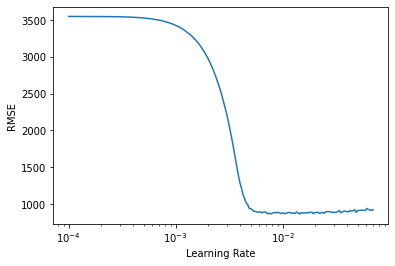

In [15]:
import matplotlib.pyplot as plt
plt.xlabel("Learning Rate")
plt.ylabel("RMSE") #Lower MSE value better the model performs
plt.semilogx(history.history["lr"], history.history["root_mean_squared_error"])
plt.xticks()

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 11 Text major ticklabel objects>)

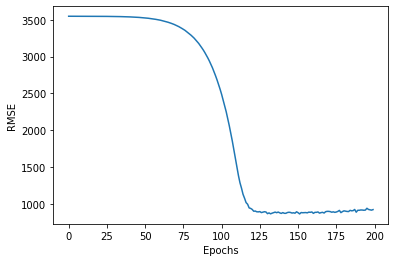

In [16]:
plt.xlabel("Epochs")
plt.ylabel("RMSE") #Lower RMSE value better the model performs
plt.plot(history.history["root_mean_squared_error"])
plt.xticks()

## Model Training based on graph above

In [17]:
model = tf.keras.Sequential([
                             norm,
                             tf.keras.layers.Dense(units=2048, activation='relu',kernel_initializer='he_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=1024, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=512, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=128, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=1),
])

In [18]:
tf.keras.backend.clear_session()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
)

model_checkpt = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True,
     monitor ='val_mean_absolute_percentage_error',
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=70) #30

history = model.fit(
    train_features,
    train_labels,
    epochs= 500,
    validation_data=(val_features, val_labels),
    callbacks=[early_stopping, model_checkpt],
    verbose=True, 
    shuffle=True
)

Epoch 1/500
31/31 [==============================] - 6s 156ms/step - loss: 3446.4121 - root_mean_squared_error: 3547.2751 - mean_absolute_percentage_error: 99.9948 - val_loss: 3400.9541 - val_root_mean_squared_error: 3505.0269 - val_mean_absolute_percentage_error: 99.8685
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 3446.0486 - root_mean_squared_error: 3546.9429 - mean_absolute_percentage_error: 99.9831 - val_loss: 3401.7710 - val_root_mean_squared_error: 3505.9197 - val_mean_absolute_percentage_error: 99.8909
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 3445.6384 - root_mean_squared_error: 3546.5063 - mean_absolute_percentage_error: 99.9716 - val_loss: 3402.0461 - val_root_mean_squared_error: 3506.2234 - val_mean_absolute_percentage_error: 99.8980
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 3445.0146 - root_mean_squared_error: 3545.9124 - mean_absolute_percentage_error: 99.9521 - val_loss: 3401.6545 -

## Visualizing the Results

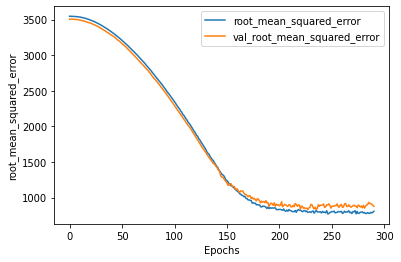

In [23]:
from matplotlib import pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, "val_"+string])
  plt.show()
  
plot_graphs(history, "root_mean_squared_error")

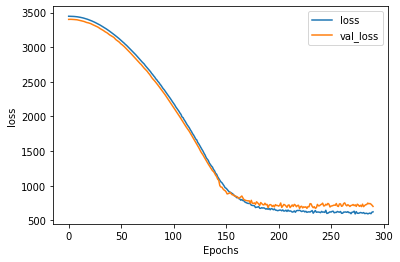

In [24]:
plot_graphs(history, "loss")

In [21]:
X = np.array([0.1022722539, 165, 97.50806]) 
Y = np.array([0.2364922396, 135, 97.5])
model = tf.keras.models.load_model("my_checkpoint")
model.predict(X.reshape(1,3))

array([[3791.5786]], dtype=float32)

In [22]:
model.evaluate(
    val_features,
    val_labels,
    verbose=1
)

6/6 [==============================] - 0s 4ms/step - loss: 683.4666 - root_mean_squared_error: 876.5770 - mean_absolute_percentage_error: 19.3935


[683.466552734375, 876.5770263671875, 19.39348602294922]